In [609]:
import corner
import pickle
import torch
import emcee
import numpy as np
import torch.distributions as dist
import matplotlib.pyplot as plt

from scipy import stats
from multiprocessing import Pool
from sbi.utils import process_prior
from interpolate_lcs import ugrizy_to_numbers
from models.magnetar_model import gen_magnetar_model
from torch.distributions import Distribution, constraints, Normal
from astropy.cosmology import WMAP9 as cosmo

from models.distributions import TruncatedNormal

import sys
sys.path.append('/Users/adamboesky/Research/SBI_205/models')

In [2]:
# Import the LCs
lcs = np.load('data/full_lcs_interped.npz', allow_pickle=True)['lcs']
lcs = np.array([lc for lc in lcs if np.mean(lc.snrs) > 3])
for lc in lcs:  # adjust the t explosion
    lc.theta[-1] -= min(lc.times)
    lc.theta[-1] *= -1
lcs.shape

(12525,)

In [3]:
def log_likelihood(xs, y, yerr, filts, theta, z, dist_const):
    pass
def log_probability(theta, ts, y, yerr, filts, z, dist_const):
    pass

In [670]:
# Get the data
ind = 21
with open(f'/Users/adamboesky/Research/SBI_205/data/mcmc_results2/mcmc_results{ind}.pkl', 'rb') as f:
    final_results, sampler = pickle.load(f)

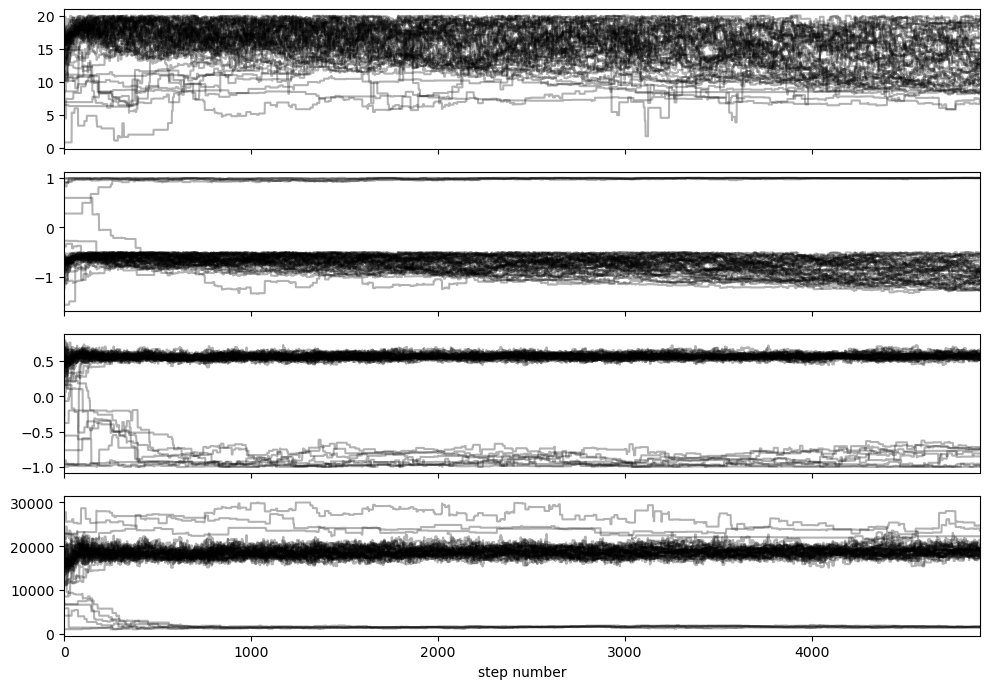

In [671]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
for i in range(4):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    # ax.set_ylabel(predictor_labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")
plt.tight_layout()
plt.show()

[ 8.25007816  0.56505089  0.98984088 29.67200752  3.22590257]


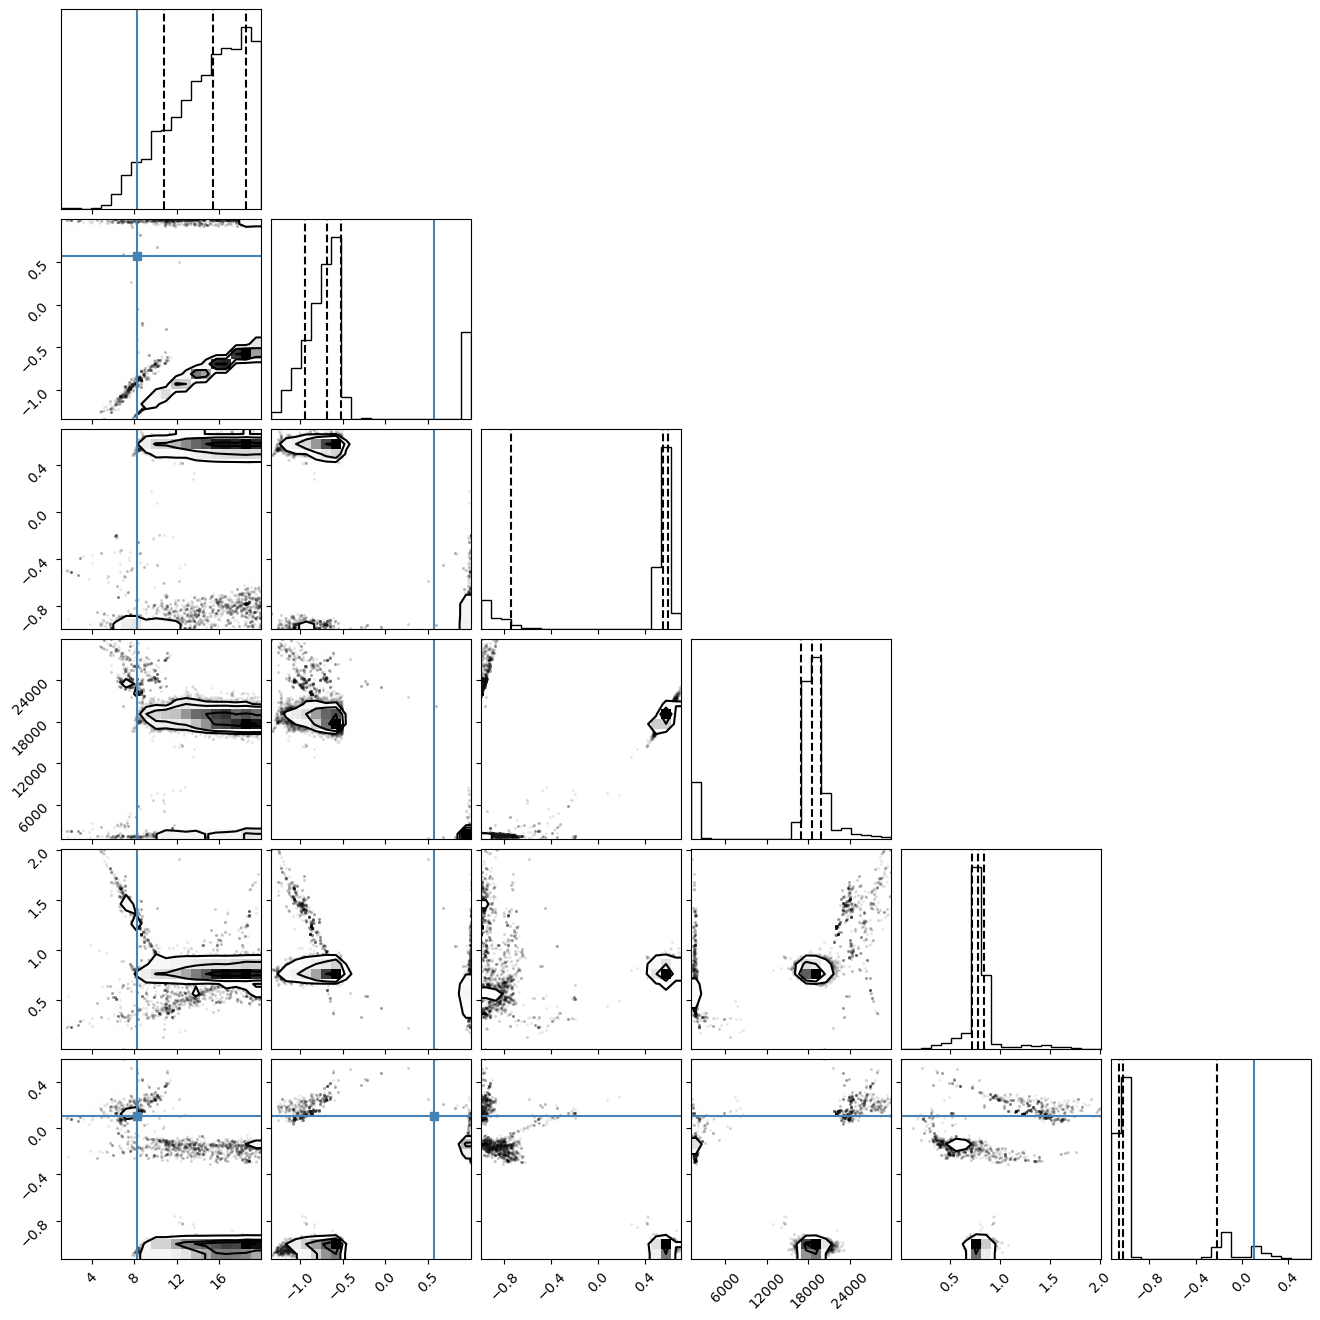

In [672]:
# Get samples
samples = sampler.get_chain(discard=100, thin=15, flat=True)
samples.shape

true = np.copy(lcs[ind].theta)[[ True,  True, False, False, False, False, False,  True,  True, False, True]]
true[1] = np.log10(true[1])
true[2] = np.log10(true[2])
true[3] = true[3] / 1000
print(true)
corner.corner(samples, truths=np.concatenate((true, [0.1])), quantiles=[0.16, 0.5, 0.84])
plt.show()

In [460]:
# Tensorize the data
ts = [np.array(lc.times) - np.min(lc.times) for lc in lcs]
orig_ts = [np.array(lc.times) for lc in lcs]
# thetas = torch.tensor([lc.theta for lc in lcs])[:, predictor_mask]
filters = [ugrizy_to_numbers(lc.filters).astype(int) for lc in lcs]
zs = [lc.redshift for lc in lcs]
lumdists = cosmo.luminosity_distance(zs)
dist_consts = torch.tensor(np.log10(4. * np.pi * (lumdists.cgs.value) ** 2))
ys = [torch.tensor(lc.mags) for lc in lcs]
yerrs = [torch.tensor((1/lc.snrs) * lc.mags) for lc in lcs]

In [451]:
from models import magnetar_model
from importlib import reload
reload(magnetar_model)
# from magnetar_model import gen_magnetar_model

<module 'models.magnetar_model' from '/Users/adamboesky/Research/SBI_205/models/magnetar_model.py'>

/Users/adamboesky/Research/SBI_205/models/magnetar_model.py:65: RuntimeWarning: divide by zero encountered in power
  l_out = multiplier * cumtrapz(integrand, test_t, initial = 0)


[6.0156277  6.21067537 5.69508158 5.68302247 3.750191   2.67392287
 3.07808645 2.50894279 2.82343323 1.93432922 1.54217012 1.49372275
 2.08912462 1.64894609 1.98282862 2.47882592 2.29974422 1.80001498
 2.20272889 1.99981117 2.3497825  2.34934839 2.33301873 2.33265537
 1.75210576 2.10939378 1.69140207 1.78878119 1.95404329 2.09521181
 1.98830874 2.10095387 2.20331103 1.91872491 2.00641451 2.00646442
 2.10871105 2.10873594 2.13014793 2.22012059 2.05969609 2.05971824
 2.62561947 2.72221676 2.37253357 2.81801929 2.43122999 2.41024808
 2.53367721 2.73595689 2.60186814 2.99429442 3.01693717 3.44842795
 3.31424639 5.49812508]


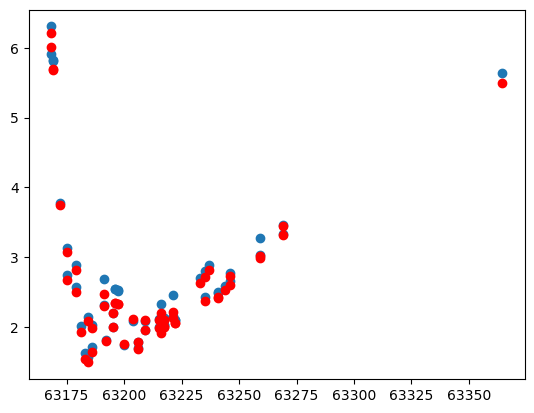

In [472]:
# Data
mns = 1.40000000e+00
thetapb = 1.57079633e+00
texp = 0.00000000e+00
kappa = 1.12600000e-01
kappagamma = 1.00000000e-01
tfloor = 6.00000000e+03
theta = np.median(samples, axis=0)
# theta = true
filts = filters[ind]
z = zs[ind]
dist_const = dist_consts[ind]

y_pred = magnetar_model.gen_magnetar_model(np.array(ts[ind]) + theta[4],
                            torch.tensor([theta[0], 10**theta[1], mns, thetapb, texp, kappa, kappagamma, 10**theta[2], theta[3]*1000, tfloor]),
                            filt=filts,
                            redshift=z,
                            dist_const=dist_const)
plt.scatter(lcs[ind].times, lcs[ind].mags)
print(y_pred)
plt.scatter(lcs[ind].times, y_pred, color='red')

In [554]:
from models.custom_sklearn import train_test_split
with open('data/full_encoded_lcs.pkl', 'rb') as f:
    encoded_lcs, lcs = pickle.load(f)

# Filter for snr > 3
# encoded_lcs     = np.array([e_lc for e_lc, lc in zip(encoded_lcs, lcs) if np.mean(lc.snrs) > 3])
lcs             = np.array([lc   for e_lc, lc in zip(encoded_lcs, lcs) if np.mean(lc.snrs) > 3])
for lc in lcs:  # adjust the t explosion
    lc.theta[-1] -= min(lc.times)
    lc.theta[-1] *= -1
lcs.shape

# Split into test and train (here we'll only do mcmc for the test batch)
# lcs_train, lcs_test = train_test_split(lcs, random_state=22, test_size=0.2)
# lcs = lcs_test

In [558]:
# Import the LCs
lcs = np.load('data/full_lcs_interped.npz', allow_pickle=True)['lcs']
lcs = np.array([lc for lc in lcs if np.mean(lc.snrs) > 3])
for lc in lcs:  # adjust the t explosion
    lc.theta[-1] -= min(lc.times)
    lc.theta[-1] *= -1
lcs.shape

# with open('data/full_encoded_lcs.pkl', 'rb') as f:
#     encoded_lcs, lcs = pickle.load(f)

# # Filter for snr > 3
# encoded_lcs     = np.array([e_lc for e_lc, lc in zip(encoded_lcs, lcs) if np.mean(lc.snrs) > 3])
# lcs             = np.array([lc   for e_lc, lc in zip(encoded_lcs, lcs) if np.mean(lc.snrs) > 3])
lcs_train, lcs = train_test_split(lcs, random_state=22, test_size=0.2)

In [679]:
# Get the data
ind = 200
with open(f'/Users/adamboesky/Research/SBI_205/data/mcmc_results_final/mcmc_results{ind}.pkl', 'rb') as f:
    final_results, sampler = pickle.load(f)

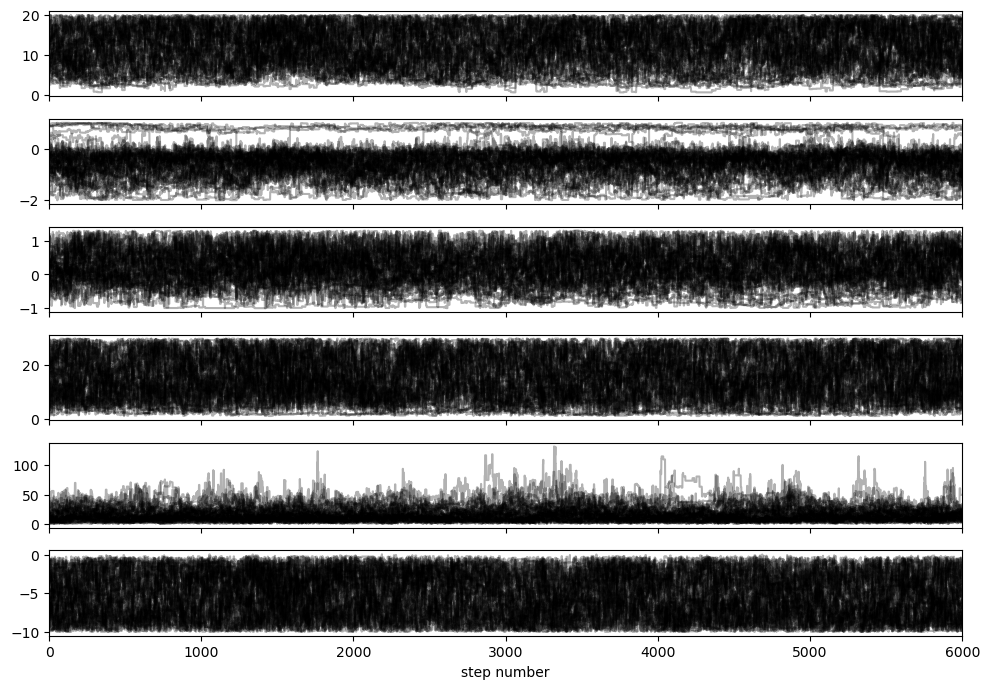

In [680]:
fig, axes = plt.subplots(6, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
for i in range(6):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    # ax.set_ylabel(predictor_labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")
plt.tight_layout()
plt.show()

[ 10.48465264  -0.61586776   0.87304354  20.38859172 173.77073922]


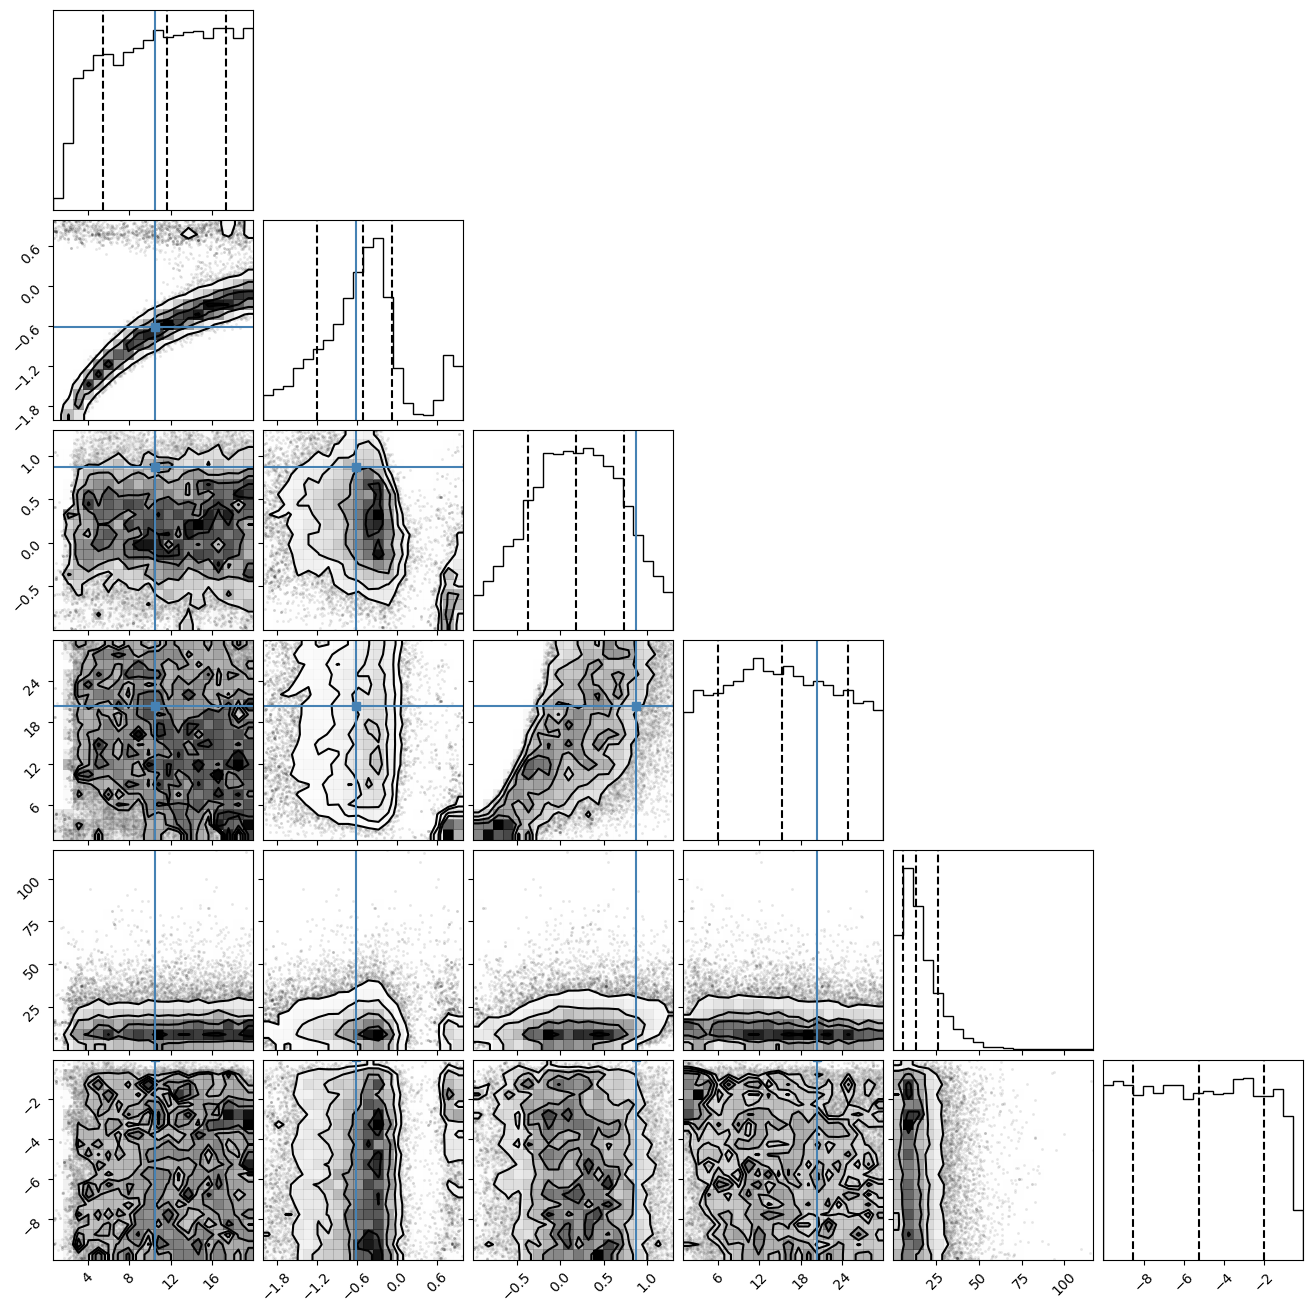

In [681]:
# Get samples
samples = sampler.get_chain(discard=100, thin=15, flat=True)
samples.shape

true = np.copy(lcs[ind].theta)[[ True,  True, False, False, False, False, False,  True,  True, False, True]]
true[1] = np.log10(true[1])
true[2] = np.log10(true[2])
true[3] = true[3] / 1000
print(true)
corner.corner(samples, truths=np.concatenate((true, [0.1])), quantiles=[0.16, 0.5, 0.84])
plt.show()

In [584]:
# Tensorize the data
ts = [np.array(lc.times) - np.min(lc.times) for lc in lcs]
orig_ts = [np.array(lc.times) for lc in lcs]
# thetas = torch.tensor([lc.theta for lc in lcs])[:, predictor_mask]
filters = [ugrizy_to_numbers(lc.filters).astype(int) for lc in lcs]
zs = [lc.redshift for lc in lcs]
lumdists = cosmo.luminosity_distance(zs)
dist_consts = torch.tensor(np.log10(4. * np.pi * (lumdists.cgs.value) ** 2))
ys = [torch.tensor(lc.mags) for lc in lcs]
yerrs = [torch.tensor((1/lc.snrs) * lc.mags) for lc in lcs]

In [585]:
from models import magnetar_model
from importlib import reload
reload(magnetar_model)
# from magnetar_model import gen_magnetar_model

<module 'models.magnetar_model' from '/Users/adamboesky/Research/SBI_205/models/magnetar_model.py'>

[20.45489091 20.52504412 20.41934312 20.46016608 20.46933043 20.46953994
 20.50497239 20.46917184 20.49308132 20.7682685  20.65659121 21.8610598
 21.13026205 20.88200835 20.74153089 23.25494313 21.30157599 21.32413802
 21.32528527 21.3850017  22.04404038 22.04407907 21.65988571 21.65991714
 21.78909069 21.54996763 23.0978357  22.29581675 21.67154233 21.67297876
 21.93966532 21.94054112 22.23184679 21.94772144 23.62821032 22.74639525
 25.39594977 25.39596539 23.67046382 23.67047941 22.789645   22.30700537
 22.82430525 22.82432151 22.34169441 22.34171066 27.65030357 23.74495712
 23.81844249 27.72544676 27.76051742 25.6161611  25.6161942  23.8907169
 23.89074983 25.65368332 25.65370018 23.92826593 23.92828281 23.99344401
 23.11768155 22.63459596 24.06322287 23.18134211 23.32082075 23.32083481
 22.83809154 22.83810558 22.86733648 22.58347288 22.93418341 23.41847115
 24.3654979  23.48349246 23.18934234 23.18959568 23.67359836 23.67385091
 24.58679864 24.58697105 23.70474426 23.7049163  26.3

/Users/adamboesky/Research/SBI_205/models/magnetar_model.py:65: RuntimeWarning: divide by zero encountered in power
  l_out = multiplier * cumtrapz(integrand, test_t, initial = 0)


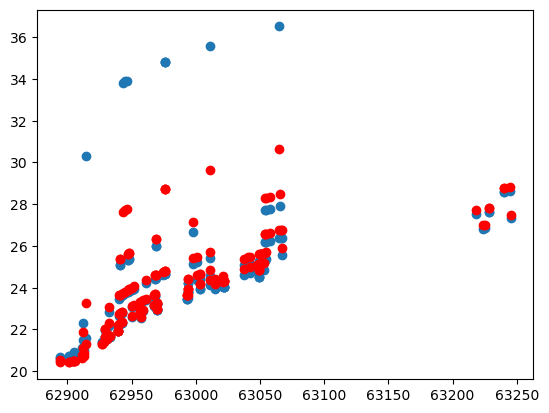

In [654]:
# Data
mns = 1.40000000e+00
thetapb = 1.57079633e+00
texp = 0.00000000e+00
kappa = 1.12600000e-01
kappagamma = 1.00000000e-01
tfloor = 6.00000000e+03
theta = np.median(samples, axis=0)
# theta = true
filts = filters[ind]
z = zs[ind]
dist_const = dist_consts[ind]

y_pred = magnetar_model.gen_magnetar_model(np.array(ts[ind]) + theta[4],
                            torch.tensor([theta[0], 10**theta[1], mns, thetapb, texp, kappa, kappagamma, 10**theta[2], theta[3]*1000, tfloor]),
                            filt=filts,
                            redshift=z,
                            dist_const=dist_const)
plt.scatter(lcs[ind].times, lcs[ind].mags)
print(y_pred)
plt.scatter(lcs[ind].times, y_pred, color='red')

In [507]:
# comparing both of the lcs files
with open('data/full_encoded_lcs.pkl', 'rb') as f:
    _, lcs1 = pickle.load(f)

lcs2 = np.load('data/full_lcs_interped.npz', allow_pickle=True)['lcs']
lcs2 = np.array([lc for lc in lcs2 if np.mean(lc.snrs) > 3])

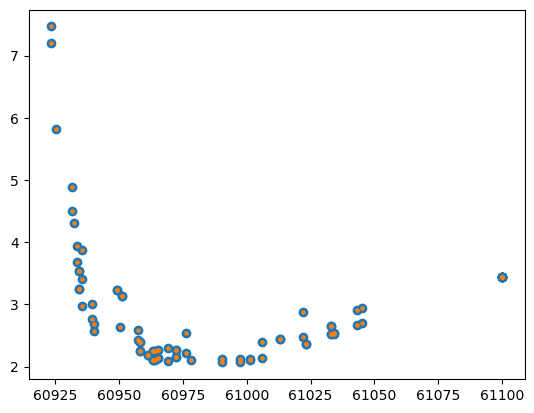

In [513]:
plt.scatter(lcs1[10].times, lcs1[10].mags)
plt.scatter(lcs2[10].times, lcs2[10].mags, s=5)